In [57]:
import warnings

warnings.simplefilter(action ='ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import os
import PIL
import shutil
import random
import glob
import itertools

%matplotlib inline

In [58]:
# Define the path to the test directory
train_dir_main = '/kaggle/input/cat-and-dog-vgg16/training_set/training_set'
test_dir_main = '/kaggle/input/cat-and-dog-vgg16/test_set/test_set'

In [59]:
# Count files in subdirectories
def count_images_in_folders(directory):
    folders = os.listdir(directory)
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images_count = len(os.listdir(folder_path))
            print(f"Folder: {folder}, Images Count: {images_count}")

In [60]:
# Print files in subdirectories
print("Train Set:")
count_images_in_folders(train_dir_main)

print("\nTest Set:")
count_images_in_folders(test_dir_main)

Train Set:
Folder: dogs, Images Count: 4006
Folder: cats, Images Count: 4001

Test Set:
Folder: dogs, Images Count: 1013
Folder: cats, Images Count: 1012


In [61]:
# Define destination directories
train_dir = "/kaggle/working/training_set"
valid_dir = "/kaggle/working/validation_set"
test_dir = "/kaggle/working/test_set"

In [62]:
# Create validation directory if it does not exist
os.makedirs(valid_dir, exist_ok=True)

In [63]:
# Function to copy files
def copy_files(src_dir, dst_dir, category, num_files):
    os.makedirs(os.path.join(dst_dir, category), exist_ok=True)
    files = os.listdir(os.path.join(src_dir, category))
    num_files_to_copy = min(num_files, len(files))
    files_to_copy = files[:num_files_to_copy]
    for file in files_to_copy:
        src_path = os.path.join(src_dir, category, file)
        dst_path = os.path.join(dst_dir, category, file)
        shutil.copy(src_path, dst_path)

In [64]:
# Copy 1000 cats and dogs from the train set to the training directory
copy_files(train_dir_main, train_dir, 'cats', 500)
copy_files(train_dir_main, train_dir, 'dogs', 500)

# Copy 500 cats and dogs from the test set to the test directory
copy_files(test_dir_main, test_dir, 'cats', 250)
copy_files(test_dir_main, test_dir, 'dogs', 250)

# Copy 500 cats and 500 dogs from the test set to the validation directory
copy_files(test_dir_main, valid_dir, 'cats', 250)
copy_files(test_dir_main, valid_dir, 'dogs', 250)

# Print files in directories
print("Train Directory:")
count_images_in_folders(train_dir)
print("\nTest Directory:")
count_images_in_folders(test_dir)
print("\nValidation Directory:")
count_images_in_folders(valid_dir)

Train Directory:
Folder: cats, Images Count: 500
Folder: dogs, Images Count: 500

Test Directory:
Folder: cats, Images Count: 250
Folder: dogs, Images Count: 250

Validation Directory:
Folder: cats, Images Count: 250
Folder: dogs, Images Count: 250


# Data preparation

In [65]:
# Define the image size and batch size
image_size = (224,224)
batch_size = 10

In [66]:
# Create an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [67]:
# Create the train_batches using flow_from_directory
train_batches = datagen.flow_from_directory(
      train_dir,
      target_size=image_size,
      batch_size=batch_size,
      classes=['cats','dogs']
)

Found 1000 images belonging to 2 classes.


In [68]:
# Create the train_batches using flow_from_directory
test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['cats', 'dogs']
)

Found 499 images belonging to 2 classes.


In [69]:
# Create the valid_batches using flow_from_directory
valid_batches = datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['cats', 'dogs']
)

Found 499 images belonging to 2 classes.


In [70]:
train_total_images = len(train_batches.filenames)
valid_total_images = len(valid_batches.filenames)
test_total_images = len(test_batches.filenames)

print(f"Total Train Images: {train_total_images}, Total Valid Images: {valid_total_images}, Total Test Images: {test_total_images}")

Total Train Images: 1000, Total Valid Images: 499, Total Test Images: 499


In [71]:
assert train_batches.n == 1000
assert test_batches.n == 499
assert valid_batches.n == 499
assert train_batches.num_classes == test_batches.num_classes == valid_batches.num_classes == 2

In [72]:
imgs, labels = next(train_batches)

# Data visualization

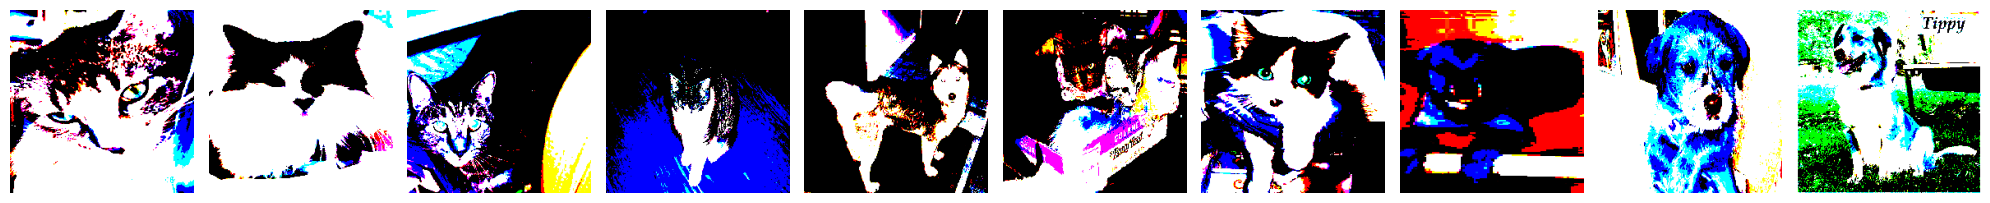

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [73]:
# Create plot function
def plotImages(images_arr) :
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes. flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Print images & labels
plotImages(imgs)
print(labels)

# Build model

In [74]:
# Download model from "https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16"
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [75]:
# Print model structure
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Create function for count_params
def count_params(model):
    """Count the total number of trainable and non-trainable parameters in the model."""
    non_trainable_params = sum(v.shape.num_elements() for v in model.non_trainable_weights)
    trainable_params = sum(v.shape.num_elements() for v in model.trainable_weights)
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [77]:
# Call the function to get the counts
params = count_params(vgg16_model)

# Print the counts
print("Total trainable parameters:", params['trainable_params'])
print("Total non-trainable parameters:", params['non_trainable_params'])

Total trainable parameters: 138357544
Total non-trainable parameters: 0


# build sequential module from VGG16

In [78]:
# Create a new Sequential model
model = Sequential()

# Add layers from the VGG16 model to the new Sequential model
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

# print new Sequential model 

In [79]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# Call the function to get the counts
params = count_params(model)

# Check the counts
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 134260544

In [81]:
# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = False

In [82]:
# Adding ouput layer with softmax activation function
model.add(Dense(units=2, activation='softmax'))

In [83]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [85]:
# Call the function to get the counts
params = count_params(model)

# Check the new counts
assert params['trainable_params'] == 8194
assert params['non_trainable_params'] == 134260544

# compile vgg16

In [86]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model

In [90]:
# Train the model
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 9s - 89ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9860 - val_loss: 0.0748
Epoch 2/5
100/100 - 9s - 88ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9840 - val_loss: 0.0756
Epoch 3/5
100/100 - 9s - 87ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9860 - val_loss: 0.0756
Epoch 4/5
100/100 - 9s - 87ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9840 - val_loss: 0.0771
Epoch 5/5
100/100 - 9s - 87ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9860 - val_loss: 0.0770


In [91]:
# Check if accuracy exceeds 95%
assert max(model.history.history['accuracy']) > 0.95

# predict on the test batch

In [93]:
# Predict using the model
predictions = model.predict(x = test_batches, verbose=0)

In [94]:
# Calculate confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [95]:
#Printing classes and labels
test_batches.class_indices


{'cats': 0, 'dogs': 1}

# check metrics for evaluation

Confusion matrix, without normalization
[[133 116]
 [113 137]]


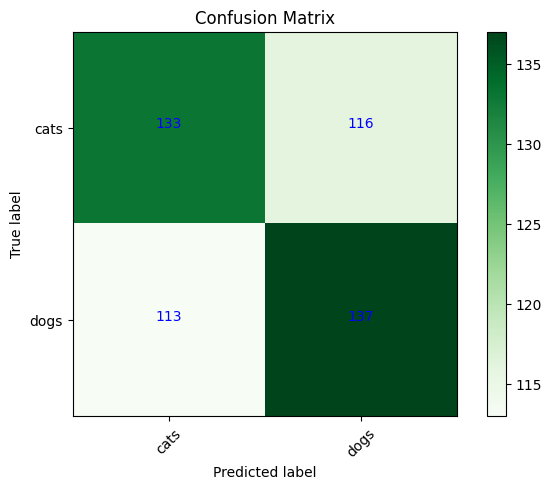

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="blue" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['cats', 'dogs']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', cmap=plt.cm.Greens)

In [98]:
# Calculate predicted classes
predicted_classes = np.argmax(predictions, axis=-1)

# Calculate accuracy
accuracy = accuracy_score(test_batches.classes, predicted_classes)

print("Accuracy on test dataset:", accuracy)

Accuracy on test dataset: 0.5410821643286573
